***
<font size="6"><center><b> B-CNN: CIFAR10 Model B </b></center></font>
***

# Imports Necessary libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import get_file
from tensorflow.keras import backend as K
# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
    #import other libraries
import math
import random

sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models
from treelib import Tree

DONE loading MixUp Data generator
DONE loading MixUp Data generator


## LOG File Directory

In [2]:
base_path = "./logs/B_CNN"
if not os.path.exists(base_path):
    os.makedirs(base_path)
    print("FOLDER CREATED = ", base_path)
else:
    print("Warning: Folder already exist.")

FOLDER CREATED =  ./logs/B_CNN


### For GPU growth (not required if GPU does not give any error)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Done: GPU "+str(gpu))
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [4]:
def scheduler(epoch):
  learning_rate_init = 0.003
  if epoch > 40:
    learning_rate_init = 0.0005
  if epoch > 50:
    learning_rate_init = 0.0001
  return learning_rate_init

In [5]:
class LossWeightsModifier(keras.callbacks.Callback):
  def __init__(self, alpha, beta, gamma):
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
  def on_epoch_end(self, epoch, logs={}):
    if epoch == 8:
      K.set_value(self.alpha, 0.1)
      K.set_value(self.beta, 0.8)
      K.set_value(self.gamma, 0.1)
    if epoch == 18:
      K.set_value(self.alpha, 0.1)
      K.set_value(self.beta, 0.2)
      K.set_value(self.gamma, 0.7)
    if epoch == 28:
      K.set_value(self.alpha, 0)
      K.set_value(self.beta, 0)
      K.set_value(self.gamma, 1)

In [6]:
#-------- dimensions ---------
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)
#-----------------------------

train_size = 50000

#--- coarse 1 classes ---
num_c_1 = 2
#--- coarse 2 classes ---
num_c_2 = 7
#--- fine classes ---
num_classes  = 10

batch_size   = 128
epochs       = 60

#--- file paths ---
log_filepath = base_path+'/tb_logs/'
weights_store_filepath = base_path+'/model_weights/'

In [7]:
#-------------------- data loading ----------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#---------------- data preprocessiong -------------------
x_train = (x_train-np.mean(x_train)) / np.std(x_train)
x_test = (x_test-np.mean(x_test)) / np.std(x_test)

#---------------------- make coarse 2 labels --------------------------
parent_f = {
  2:3, 3:5, 5:5,
  1:2, 7:6, 4:6,
  0:0, 6:4, 8:1, 9:2
}
y_c2_train = np.zeros((y_train.shape[0], num_c_2)).astype("float32")
y_c2_test = np.zeros((y_test.shape[0], num_c_2)).astype("float32")
for i in range(y_c2_train.shape[0]):
  y_c2_train[i][parent_f[np.argmax(y_train[i])]] = 1.0
for i in range(y_c2_test.shape[0]):
  y_c2_test[i][parent_f[np.argmax(y_test[i])]] = 1.0

#---------------------- make coarse 1 labels --------------------------
parent_c2 = {
  0:0, 1:0, 2:0,
  3:1, 4:1, 5:1, 6:1
}
y_c1_train = np.zeros((y_c2_train.shape[0], num_c_1)).astype("float32")
y_c1_test = np.zeros((y_c2_test.shape[0], num_c_1)).astype("float32")
for i in range(y_c1_train.shape[0]):
  y_c1_train[i][parent_c2[np.argmax(y_c2_train[i])]] = 1.0
for i in range(y_c1_test.shape[0]):
  y_c1_test[i][parent_c2[np.argmax(y_c2_test[i])]] = 1.0

In [8]:
#----------------------- model definition ---------------------------
alpha = K.variable(value=0.98, dtype="float32", name="alpha") # A1 in paper
beta = K.variable(value=0.01, dtype="float32", name="beta") # A2 in paper
gamma = K.variable(value=0.01, dtype="float32", name="gamma") # A3 in paper

In [9]:
img_input = Input(shape=input_shape, name='input')

#--- block 1 ---
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#--- block 2 ---
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

#--- coarse 1 branch ---
c_1_bch = Flatten(name='c1_flatten')(x)
c_1_bch = Dense(256, activation='relu', name='c1_fc_cifar10_1')(c_1_bch)
c_1_bch = BatchNormalization()(c_1_bch)
c_1_bch = Dropout(0.5)(c_1_bch)
c_1_bch = Dense(256, activation='relu', name='c1_fc2')(c_1_bch)
c_1_bch = BatchNormalization()(c_1_bch)
c_1_bch = Dropout(0.5)(c_1_bch)
c_1_pred = Dense(num_c_1, activation='softmax', name='c1_predictions_cifar10')(c_1_bch)

#--- block 3 ---
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#--- coarse 2 branch ---
c_2_bch = Flatten(name='c2_flatten')(x)
c_2_bch = Dense(512, activation='relu', name='c2_fc_cifar10_1')(c_2_bch)
c_2_bch = BatchNormalization()(c_2_bch)
c_2_bch = Dropout(0.5)(c_2_bch)
c_2_bch = Dense(512, activation='relu', name='c2_fc2')(c_2_bch)
c_2_bch = BatchNormalization()(c_2_bch)
c_2_bch = Dropout(0.5)(c_2_bch)
c_2_pred = Dense(num_c_2, activation='softmax', name='c2_predictions_cifar10')(c_2_bch)

#--- block 4 ---
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#--- fine block ---
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='fc_cifar10_1')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
fine_pred = Dense(num_classes, activation='softmax', name='predictions_cifar10')(x)

In [10]:
model = Model(img_input, [c_1_pred, c_2_pred, fine_pred], name='medium_dynamic')

In [11]:
model.summary()

Model: "medium_dynamic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalizatio

                                                                                                  
 fc2 (Dense)                    (None, 1024)         1049600     ['dropout_4[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 256)         1024        ['c1_fc2[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 512)         2048        ['c2_fc2[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_13 (BatchN  (None, 1024)        4096        ['fc2[0][0]']                    
 ormalizat

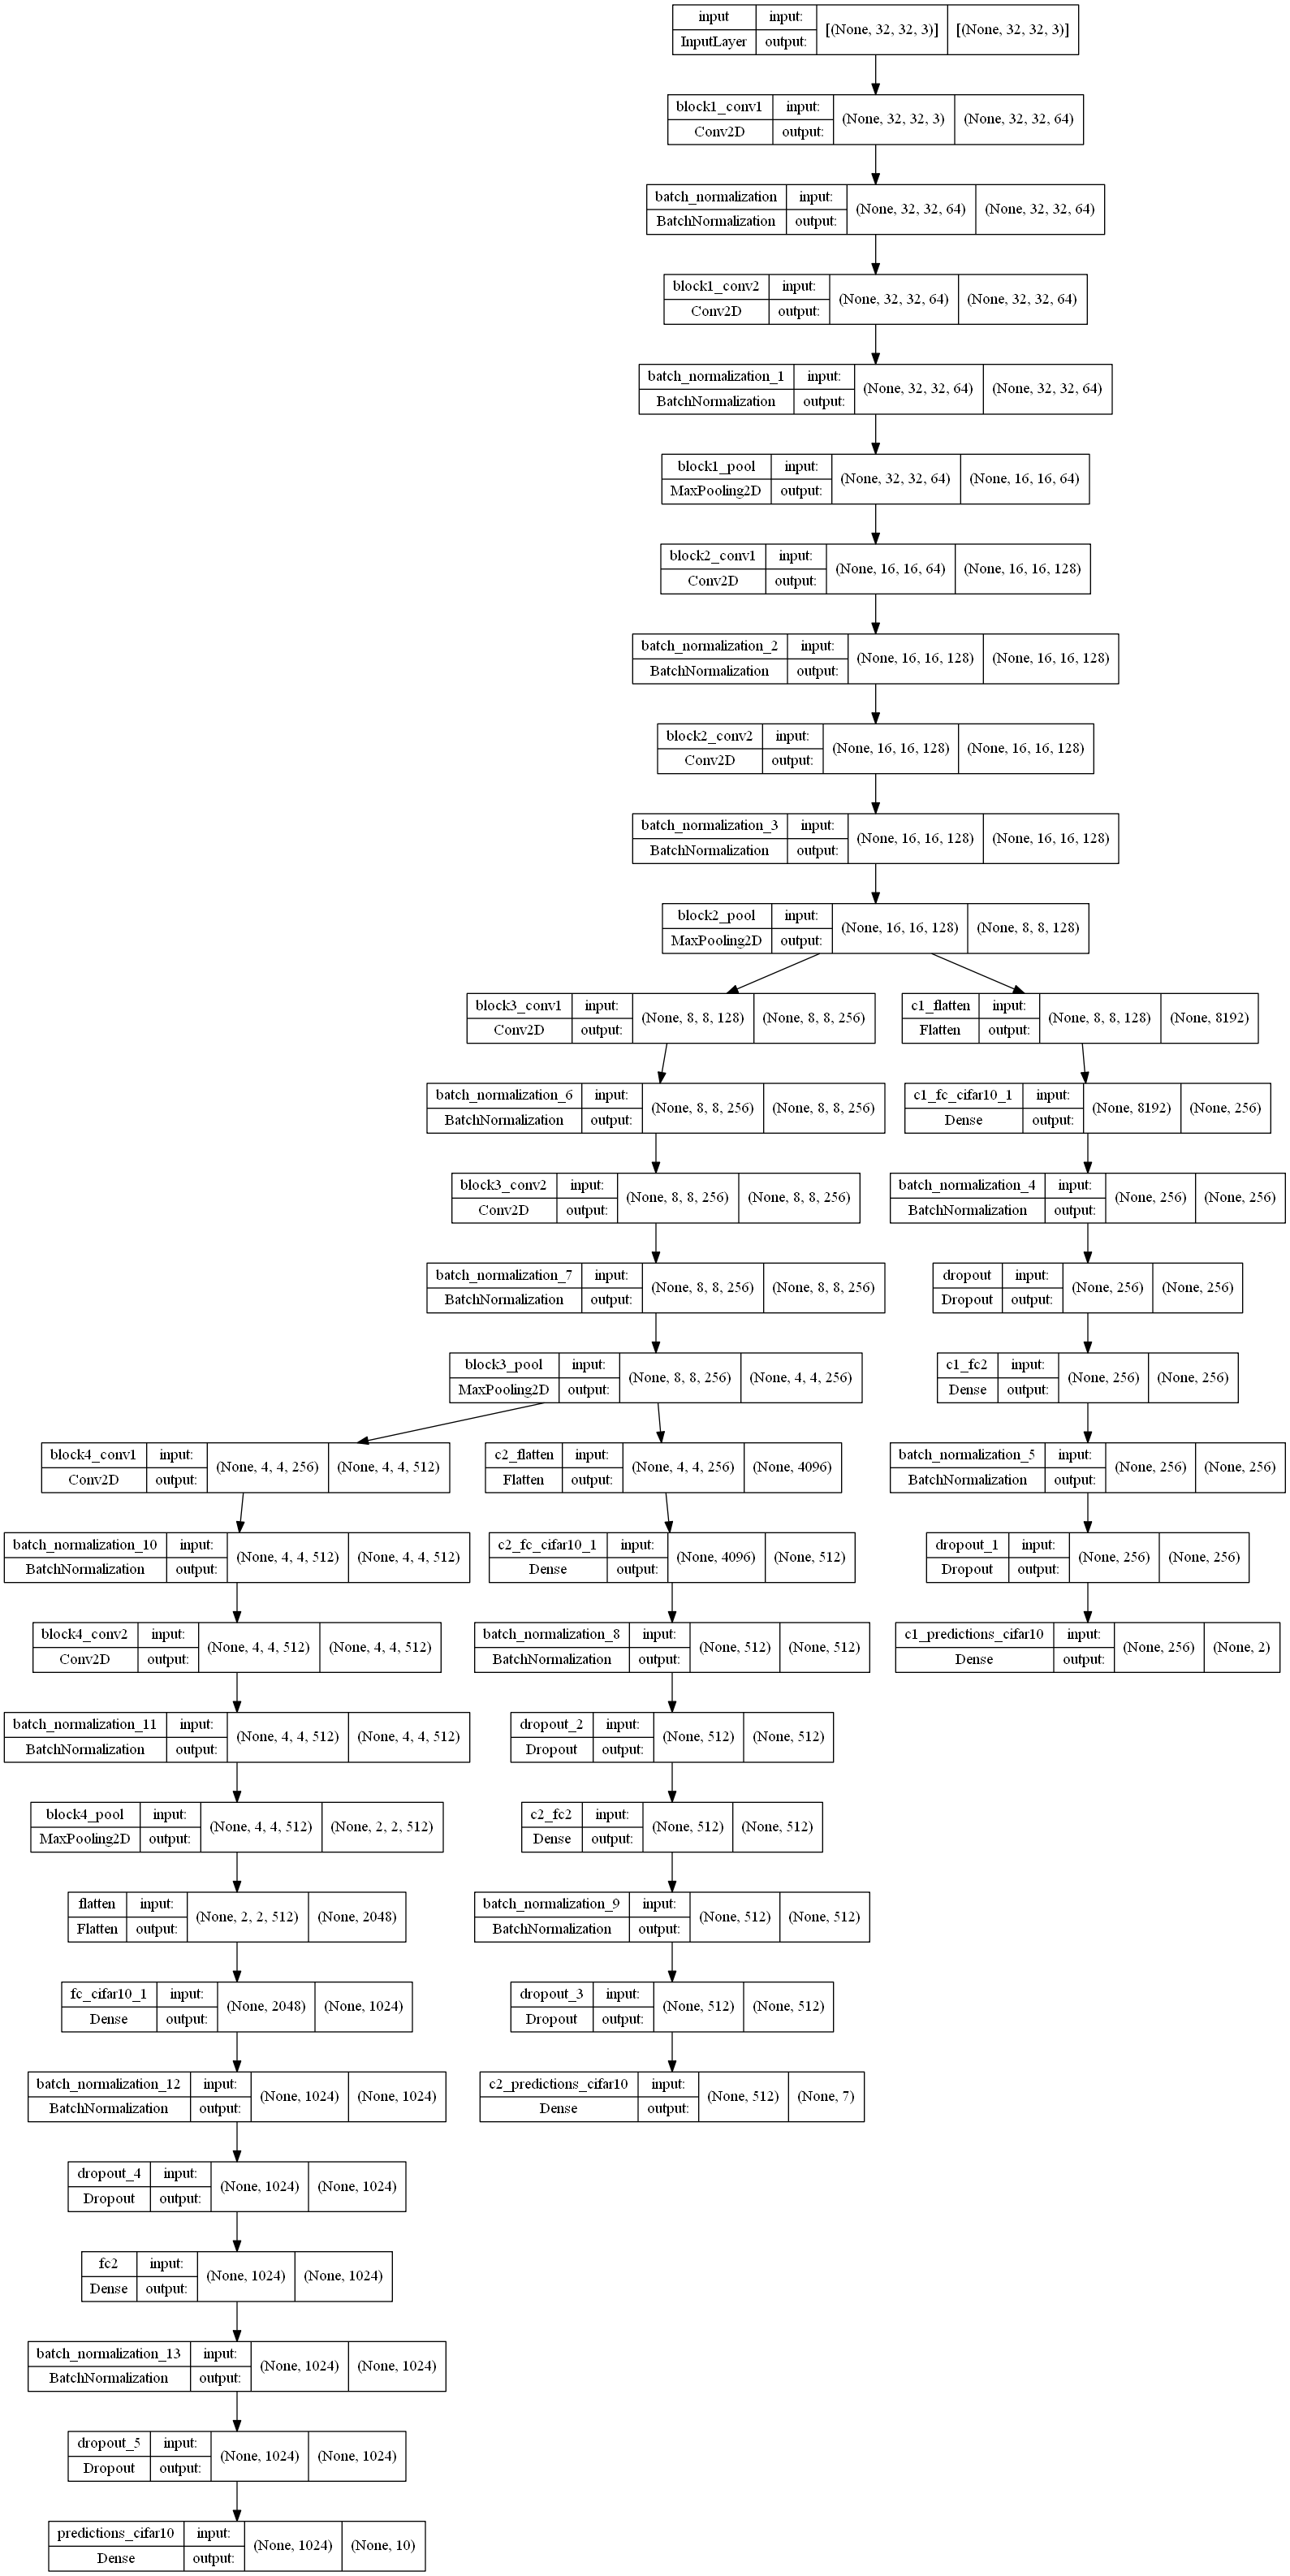

In [12]:
keras.utils.plot_model(model, base_path+"/b-cnn.png",show_shapes=True)

In [14]:
#----------------------- compile and fit ---------------------------
sgd = optimizers.SGD(lr=0.003, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              loss_weights=[alpha, beta, gamma],
              # optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

log = keras.callbacks.CSVLogger(base_path+'/log.csv', append=True)
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
change_lw = LossWeightsModifier(alpha, beta, gamma)
cbks = [change_lr, tb_cb, change_lw, log]

In [15]:
try:
    model.load_weights(base_path+'/trained_model.h5')
except:
    model.fit(x_train, [y_c1_train, y_c2_train, y_train],
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=cbks,
              validation_data=(x_test, [y_c1_test, y_c2_test, y_test]))
    model.save_weights(base_path+'/trained_model.h5')

In [16]:
score = model.evaluate(x_test, [y_c1_test, y_c2_test, y_test], verbose=1)
print('score is: ', score)

score is:  [0.11714997887611389, 0.1062336191534996, 0.46563491225242615, 0.8384686708450317, 0.9607999920845032, 0.8712999820709229, 0.8453999757766724]


In [17]:
for n in range(len(score)):
    print(str(n+1)+'.',model.metrics_names[n], '==>', score[n])

1. loss ==> 0.11714997887611389
2. c1_predictions_cifar10_loss ==> 0.1062336191534996
3. c2_predictions_cifar10_loss ==> 0.46563491225242615
4. predictions_cifar10_loss ==> 0.8384686708450317
5. c1_predictions_cifar10_accuracy ==> 0.9607999920845032
6. c2_predictions_cifar10_accuracy ==> 0.8712999820709229
7. predictions_cifar10_accuracy ==> 0.8453999757766724


# Precision & Recall

In [18]:
predictions = model.predict(x_test, verbose=1)
for n in range(len(predictions)):
    print(str(n+1)+'.',predictions[n].shape, '==>', 'predictions[{A}]'.format(A=n))

313/313 [==============================] - 3s 9ms/step
1. (10000, 2) ==> predictions[0]
2. (10000, 7) ==> predictions[1]
3. (10000, 10) ==> predictions[2]


# sklearn: Performance parameters

{0, 1}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[0, 1]
['0', '1']
[0, 1, 2, 3, 4, 5, 6]
['0', '1', '2', '3', '4', '5', '6']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

  • multilabel-Confusion_Matrix 


  • COARSE LEVEL 
[[[5844  156]
  [ 236 3764]]

 [[3764  236]
  [ 156 5844]]]

  • MEDIUM LEVEL 
[[[8834  166]
  [ 132  868]]

 [[8941   59]
  [ 101  899]]

 [[7910   90]
  [ 112 1888]]

 [[8818  182]
  [ 278  722]]

 [[8891  109]
  [ 136  864]]

 [[7593  407]
  [ 272 1728]]

 [[7726  274]
  [ 256 1744]]]

  • FINE LEVEL 
[[[8854  146]
  [ 133  867]]

 [[8917   83]
  [  74  926]]

 [[8801  199]
  [ 241  759]]

 [[8688  312]
  [ 283  717]]

 [[8809  191]
  [ 151  849]]

 [[8792  208]
  [ 235  765]]

 [[8882  118]
  [ 118  882]]

 [[8883  117]
  [ 126  874]]

 [[8928   72]
  [  84  916]]

 [[8900  100]
  [ 101  899]]]

  • Confusion_Matrix 


  • COARSE LEVEL 
[[3764  236]
 [ 156 5844]]

  • MEDIUM LEVEL 
[[ 868   19   38   32    3   19  

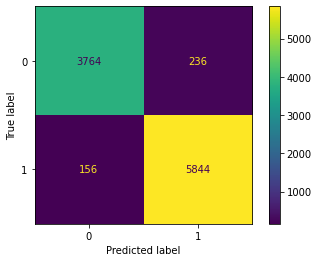

              precision    recall  f1-score   support

           0    0.96020   0.94100   0.95051      4000
           1    0.96118   0.97400   0.96755      6000

    accuracy                        0.96080     10000
   macro avg    0.96069   0.95750   0.95903     10000
weighted avg    0.96079   0.96080   0.96073     10000


  • MEDIUM LEVEL 


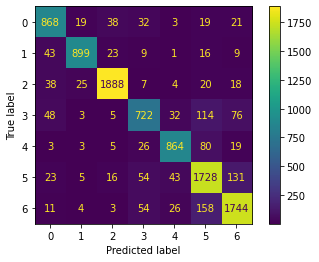

              precision    recall  f1-score   support

           0    0.83946   0.86800   0.85349      1000
           1    0.93841   0.89900   0.91828      1000
           2    0.95450   0.94400   0.94922      2000
           3    0.79867   0.72200   0.75840      1000
           4    0.88798   0.86400   0.87582      1000
           5    0.80937   0.86400   0.83579      2000
           6    0.86422   0.87200   0.86809      2000

    accuracy                        0.87130     10000
   macro avg    0.87037   0.86186   0.86559     10000
weighted avg    0.87207   0.87130   0.87122     10000


  • FINE LEVEL 


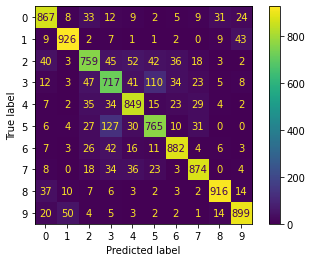

              precision    recall  f1-score   support

           0    0.85587   0.86700   0.86140      1000
           1    0.91774   0.92600   0.92185      1000
           2    0.79228   0.75900   0.77528      1000
           3    0.69679   0.71700   0.70675      1000
           4    0.81635   0.84900   0.83235      1000
           5    0.78623   0.76500   0.77547      1000
           6    0.88200   0.88200   0.88200      1000
           7    0.88194   0.87400   0.87795      1000
           8    0.92713   0.91600   0.92153      1000
           9    0.89990   0.89900   0.89945      1000

    accuracy                        0.84540     10000
   macro avg    0.84562   0.84540   0.84540     10000
weighted avg    0.84562   0.84540   0.84540     10000



In [19]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

cloarse_classes_number = num_c_1 #from model architecture
medium_classes_number = num_c_2
fine_classes_number = num_classes

y_true_coarse = np.argmax(y_c1_test, axis=1)
y_pred_coarse = np.argmax(predictions[0], axis=1)

y_true_medium = np.argmax(y_c2_test, axis=1)
y_pred_medium = np.argmax(predictions[1], axis=1)

y_true_fine = np.argmax(y_test, axis=1)
y_pred_fine = np.argmax(predictions[2], axis=1)

output = set()
for x in y_true_coarse:
    output.add(x)
print(output)

for x in y_true_medium:
    output.add(x)
print(output)

for x in y_true_fine:
    output.add(x)
print(output)

coarse_labels = list(range(0, cloarse_classes_number))
coarse_target_names = [str(x) for x in list(range(0, cloarse_classes_number))]
medium_labels = list(range(0, medium_classes_number))
medium_target_names = [str(x) for x in list(range(0, medium_classes_number))]
fine_labels = list(range(0, fine_classes_number))
fine_target_names = [str(x) for x in list(range(0, fine_classes_number))]
print(coarse_labels)
print(coarse_target_names)
print(medium_labels)
print(medium_target_names)
print(fine_labels)
print(fine_target_names)

def confusion_matrixDisplay(y_true, y_pred, target_names):
    labels = target_names
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot()
    plt.show()
    #plt.savefig("Confusion_Matrix.png")

print('\n\033[91m','\033[1m',"\u2022",'multilabel-Confusion_Matrix','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_coarse, y_pred_coarse))
print('\n\033[91m','\033[1m',"\u2022",'MEDIUM LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_medium, y_pred_medium))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_fine, y_pred_fine))

print('\n\033[91m','\033[1m',"\u2022",'Confusion_Matrix','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
print(confusion_matrix(y_true_coarse, y_pred_coarse))
print('\n\033[91m','\033[1m',"\u2022",'MEDIUM LEVEL','\033[0m')
print(confusion_matrix(y_true_medium, y_pred_medium))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
print(confusion_matrix(y_true_fine, y_pred_fine))

print('\n\033[91m','\033[1m',"\u2022",'Classification Report','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'COARSE LEVEL','\033[0m')
confusion_matrixDisplay(y_true_coarse, y_pred_coarse, coarse_target_names)
print(classification_report(y_true_coarse, y_pred_coarse, target_names=coarse_target_names, digits=5))
print('\n\033[91m','\033[1m',"\u2022",'MEDIUM LEVEL','\033[0m')
confusion_matrixDisplay(y_true_medium, y_pred_medium, medium_target_names)
print(classification_report(y_true_medium, y_pred_medium, target_names=medium_target_names, digits=5))
print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
confusion_matrixDisplay(y_true_fine, y_pred_fine, fine_target_names)
print(classification_report(y_true_fine, y_pred_fine, target_names=fine_target_names, digits=5))

# hierarchical_PrecisionRecallF1

In [20]:
tree = Tree()
tree.create_node("Root", "root")  # root node
for i in range(2):
    tree.create_node('L0_'+ str(i), 'L0_'+ str(i), parent="root")

def mediumlevel(previous_lvl, new_lvl):
    
    tree.create_node('L1_'+str(new_lvl), 'L1_'+str(new_lvl), 'L0_'+str(previous_lvl))

def finelevel(previous_lvl, new_lvl):
    
    tree.create_node('L2_'+str(new_lvl), 'L2_'+str(new_lvl), 'L1_'+str(previous_lvl))

for i in range(len(parent_c2)):
    mediumlevel(parent_c2[i], i)

for i in range(len(parent_f)):
    finelevel(parent_f[i], i)
tree.show()

Root
├── L0_0
│   ├── L1_0
│   │   └── L2_0
│   ├── L1_1
│   │   └── L2_8
│   └── L1_2
│       ├── L2_1
│       └── L2_9
└── L0_1
    ├── L1_3
    │   └── L2_2
    ├── L1_4
    │   └── L2_6
    ├── L1_5
    │   ├── L2_3
    │   └── L2_5
    └── L1_6
        ├── L2_4
        └── L2_7



In [21]:
true_label = [y_true_coarse.tolist(), y_true_medium.tolist(), y_true_fine.tolist()]
pred_label = [predictions[0],predictions[1],predictions[2]]

In [23]:
h_measurements = metrics.get_hierarchical_metrics(true_label, pred_label, tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2])
print('\nH Accuracy=',
     metrics.get_h_accuracy(true_label, pred_label),
     '\nThis method computes the harmonic mean of accuracies of all level in the taxonomy.',)

print('\nM Accuracy=',
     metrics.get_m_accuracy(true_label, pred_label),
     '\nThis method computes the harmonic mean of accuracies of all level in the taxonomy.',
      )

print('\nExact_Match=',
     metrics.get_exact_match(true_label, pred_label),
     '\nThis method compute the exact match score. Exact match is defined as the #of examples for which the predictions for all level in the taxonomy is correct by the total #of examples.',
      )

print('\nConsistency=',
     metrics.get_consistency(pred_label, tree),
     '\nThis methods estimates the consistency.',
      )


Hierarchical Precision = 0.8926 
Hierarchical Recall = 0.9147666666666668 
Hierarchical F1-Score = 0.901782142857143

H Accuracy= 0.889842888777001 
This method computes the harmonic mean of accuracies of all level in the taxonomy.

M Accuracy= 0.8925000000000001 
This method computes the harmonic mean of accuracies of all level in the taxonomy.

Exact_Match= 0.7899 
This method compute the exact match score. Exact match is defined as the #of examples for which the predictions for all level in the taxonomy is correct by the total #of examples.

Consistency= 0.8972 
This methods estimates the consistency.
